# Second population's analysis
**INCLUDE:**
1. Data Exploration
2. Classification Algorithms
3. Regression Algorithms

In [3]:
#Data processing
import numpy as np
import pandas as pd
from sklearn import preprocessing

#Plotting
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import seaborn as sns; sns.reset_orig()

#Analysis
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, MDS
from sklearn import cluster
from sklearn import manifold

#Machine Learning Model
#Common Model Algorithms
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import tree
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import ExtraTreesClassifier, RandomTreesEmbedding
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn import ensemble

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import random_projection
from feature_cutting import drop_feature

#Model evaluation
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score


%matplotlib inline

In [4]:
df = pd.read_csv("/Users/duc_hoang/Box Sync/Fermilab Summer Research/CNN-Architectural-Analysis/MINERvA-Vertex-Finding/Data/Second-population/Second-population-attributes.csv",
                index_col = 0)

In [5]:
df = df.dropna()

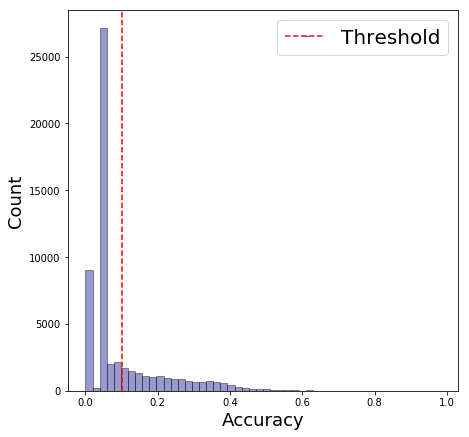

In [4]:
#histogram
fig = plt.figure(figsize=[7,7])
fig1 = sns.distplot(df["final_accuracy"],
                    hist=True, kde=False, 
                    color = 'darkblue',
                    hist_kws={'edgecolor':'black'},
                    kde_kws={'linewidth': 2}, norm_hist=False);

fig1.set_xlabel("Accuracy", fontsize = 18)
fig1.set_ylabel("Count", fontsize = 18)
plt.axvline(x = 0.100533, ls = "--", c = "red")

# Manually add legend
threshold = mlines.Line2D([], [], color='crimson', marker='_', linestyle='--',
                                    markersize=6, label='Threshold', alpha = 1)

plt.legend(handles=[threshold], fontsize = 20)

-----------------------

In [5]:
#Classification models

In [6]:
#Since there are ~15k of Healthy networks, randomly select 17k of broken networks to do classification tasks.

#Healthy
df_healthy = df[df['final_accuracy'] >= 0.100533]
#Broken
df_broken  = df[df['final_accuracy'] < 0.100533]

In [7]:
print("Number of all networks analysed: ", df.shape[0])
print("Number of Healthy Networks: ", df_healthy.shape[0])
print("Percentage Healthy: ", df_healthy.shape[0]/df.shape[0])
print("Number of Broken Networks: ", df_broken.shape[0])
print("Percentage Broken: ", df_broken.shape[0]/df.shape[0])

Number of all networks analysed:  56452
Number of Healthy Networks:  15771
Percentage Healthy:  0.2793700843194218
Number of Broken Networks:  40681
Percentage Broken:  0.7206299156805782


In [8]:
#Select out 17k networks as in healthy networks
sampled_df_broken = df_broken.sample(n = df_healthy.shape[0], random_state = 0)

In [9]:
#Merge into one
classification_df = pd.concat([sampled_df_broken, df_healthy])

In [10]:
#Select the features and dependent variable
X = classification_df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy']) #Features
y = pd.Series([1 if x >= 0.100533 else 0 for x in classification_df['final_accuracy']]) #dependent variable

In [11]:
#Divide train and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state=0)

In [12]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
# Don't cheat - fit only on training data
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
# apply same transformation to test data
X_test = scaler.transform(X_test)  

In [13]:
#Explore random forest
rf = RandomForestClassifier(n_estimators=200,
                             max_depth=17, bootstrap = False,  min_samples_split=2, 
                             warm_start = True, random_state=0)

rf.fit(X_train, y_train)

print("Accuracy : %f" % rf.score(X_test, y_test))

Accuracy : 0.706768


In [14]:
rf_cross_vals = cross_val_score(rf, X_train, y_train, cv = 5)
print("Cross-validation score on train set: ", np.average(rf_cross_vals))
print("Standard error of cross validation scores: ", np.std(rf_cross_vals))

Cross-validation score on train set:  0.695675877842499
Standard error of cross validation scores:  0.0059389280960560585


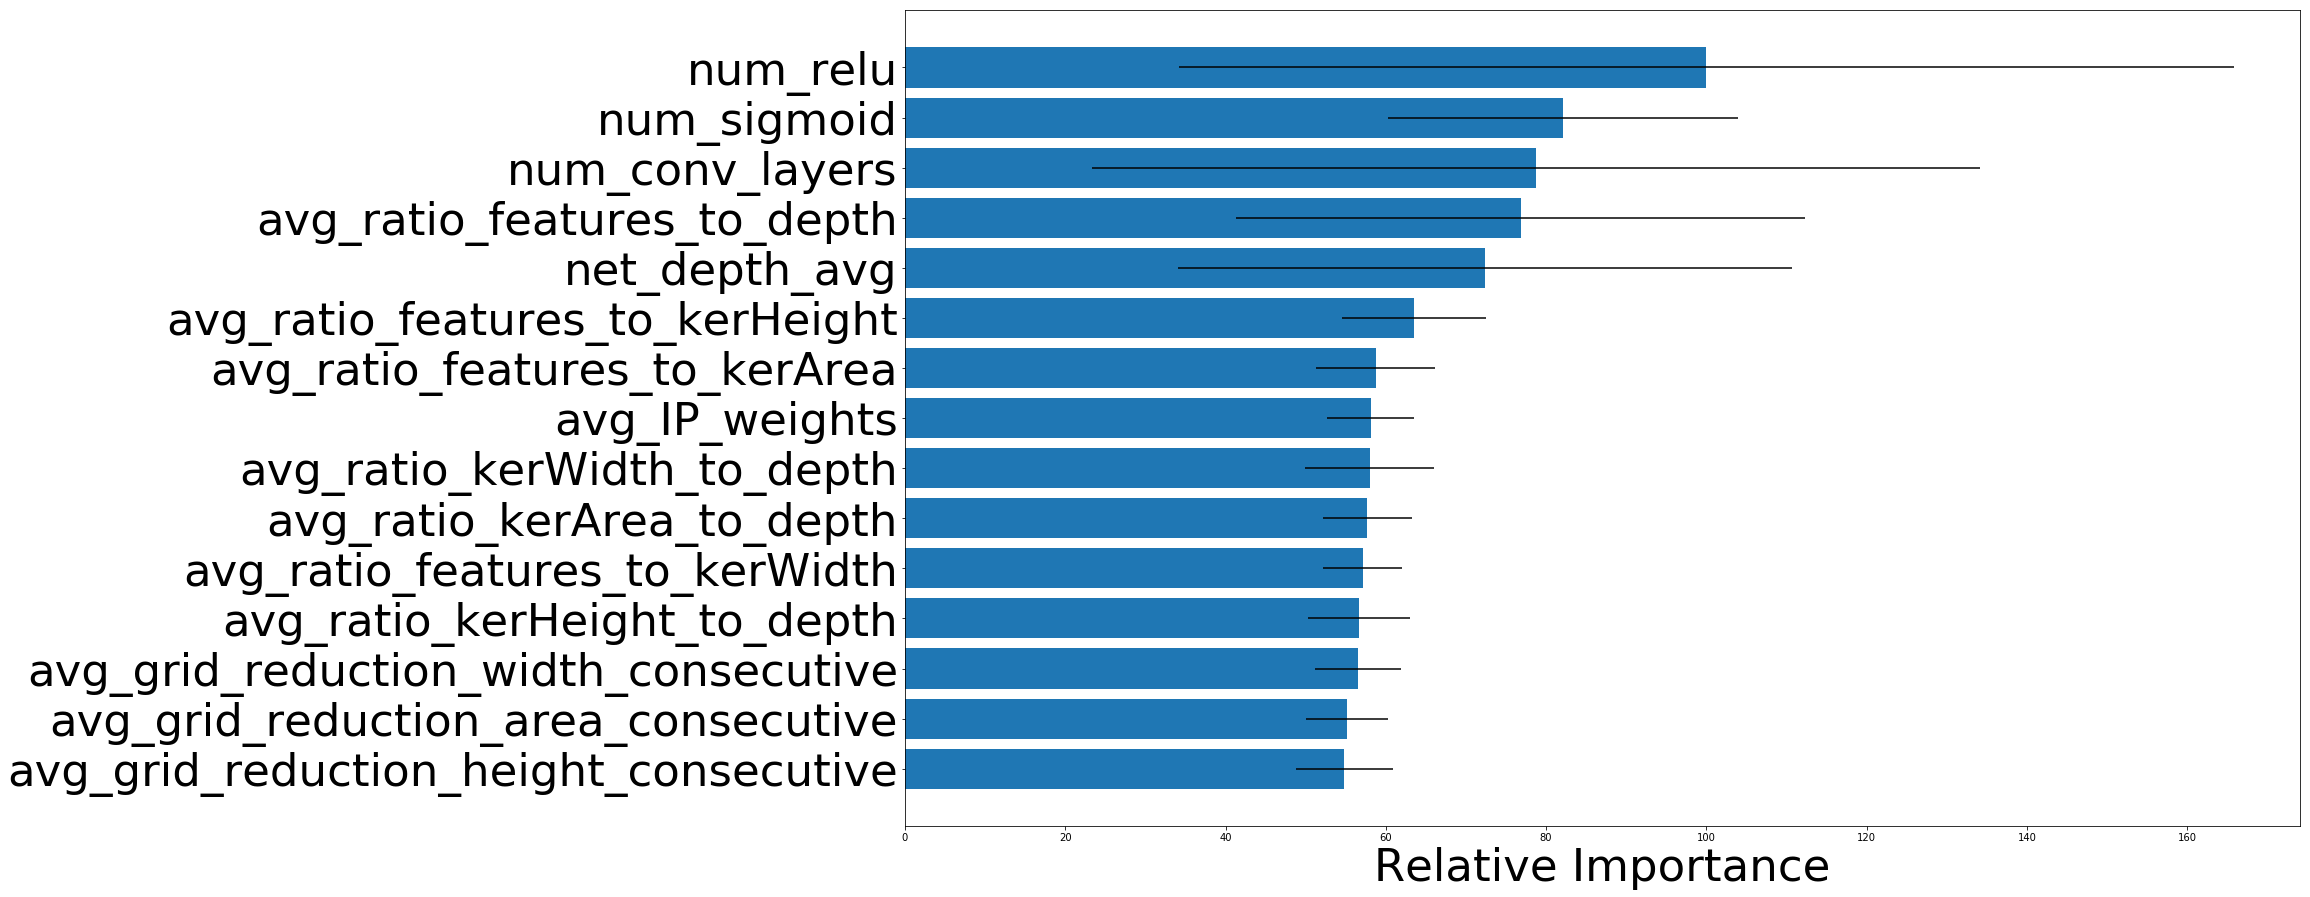

In [35]:
#Feature Importance extraction
feature_importance1 = rf.feature_importances_

# Compute the standard deviation
std1 = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

#scale the std first
std1 = 100.0 * (std1/ feature_importance1.max())

# make importances relative to max importance
feature_importance1 = 100.0 * (feature_importance1 / feature_importance1.max())

features_importance_rf1 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance1, "Error":std1})

Sorted_Features_importance_rf1 = features_importance_rf1.sort_values(by=['Importance'])

#Just show the first 15 most important features
toShow_15 = Sorted_Features_importance_rf1.iloc[-15:,:]
pos = np.arange(toShow_15.shape[0]) + .5

#Plotting
fig = plt.figure(figsize = [25,15])
plt.barh(pos, toShow_15['Importance'], align='center', xerr = toShow_15['Error'])
plt.yticks(pos, toShow_15['Feature'], fontsize = 45)
plt.xlabel('Relative Importance', fontsize = 45)
plt.show()

In [15]:
#Feature Importance extraction
feature_importance1 = rf.feature_importances_

# Compute the standard deviation
std1 = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

features_importance_rf1 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance1, "Error":std1})

Sorted_Features_importance_rf1 = features_importance_rf1.sort_values(by=['Importance'], ascending = False)

In [16]:
#Dropping most important features
rf_crvals, std_rf_crvals, num_trimmed = drop_feature(rf,Sorted_Features_importance_rf1, X, y, 15)

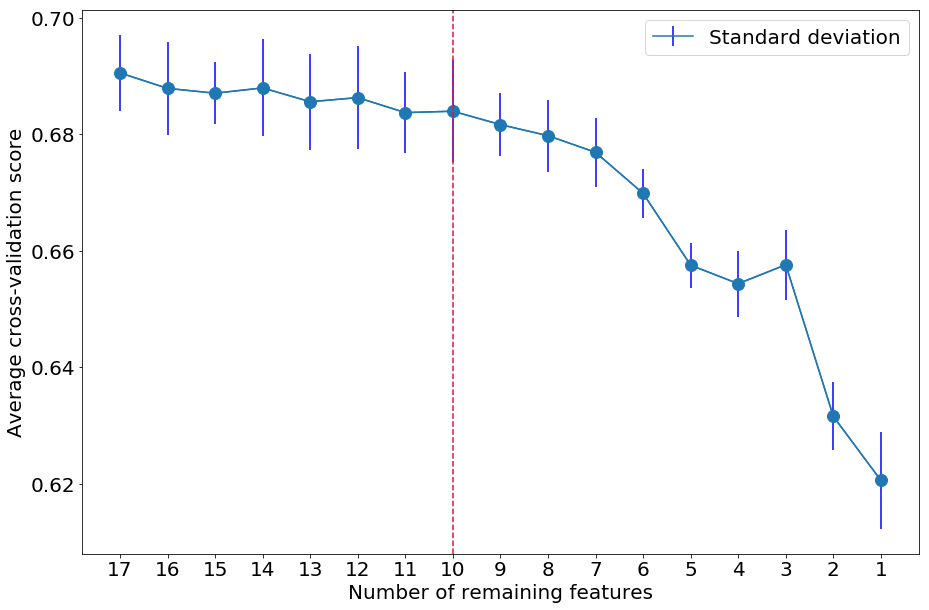

In [18]:
#Plotting
num_remaining = X.shape[1] - np.array(num_trimmed)

fig = plt.figure(figsize = [15,10])
plt.plot(num_trimmed, rf_crvals,'-o', markersize = 12)

#Set ticks
plt.yticks(fontsize = 20)
plt.xticks(num_trimmed,num_remaining, fontsize = 20)

#Error bars
plt.errorbar(num_trimmed, rf_crvals, yerr= std_rf_crvals, ecolor = "blue",
            label='Standard deviation')

plt.legend(loc="best", fontsize = 20)

#Set labels
plt.ylabel("Average cross-validation score", fontsize = 20)
plt.xlabel("Number of remaining features", fontsize = 20)

#Set cut off
plt.axvline(x = 22, ls = "--", c = "crimson")

-----------------------

In [48]:
ext = ExtraTreesClassifier(n_estimators=200, max_depth=34, 
                           min_samples_split=11, bootstrap = False, 
                            warm_start = True, random_state=0)

ext.fit(X_train, y_train)

print("Accuracy : %f" % ext.score(X_test, y_test))

Accuracy : 0.702647


In [49]:
ext_cross_vals = cross_val_score(ext, X_train, y_train, cv = 5)
print("Cross-validation score on train set: ", np.average(ext_cross_vals))
print("Standard error of cross validation scores: ", np.std(ext_cross_vals))

Cross-validation score on train set:  0.6950021004028453
Standard error of cross validation scores:  0.0050243786519889545


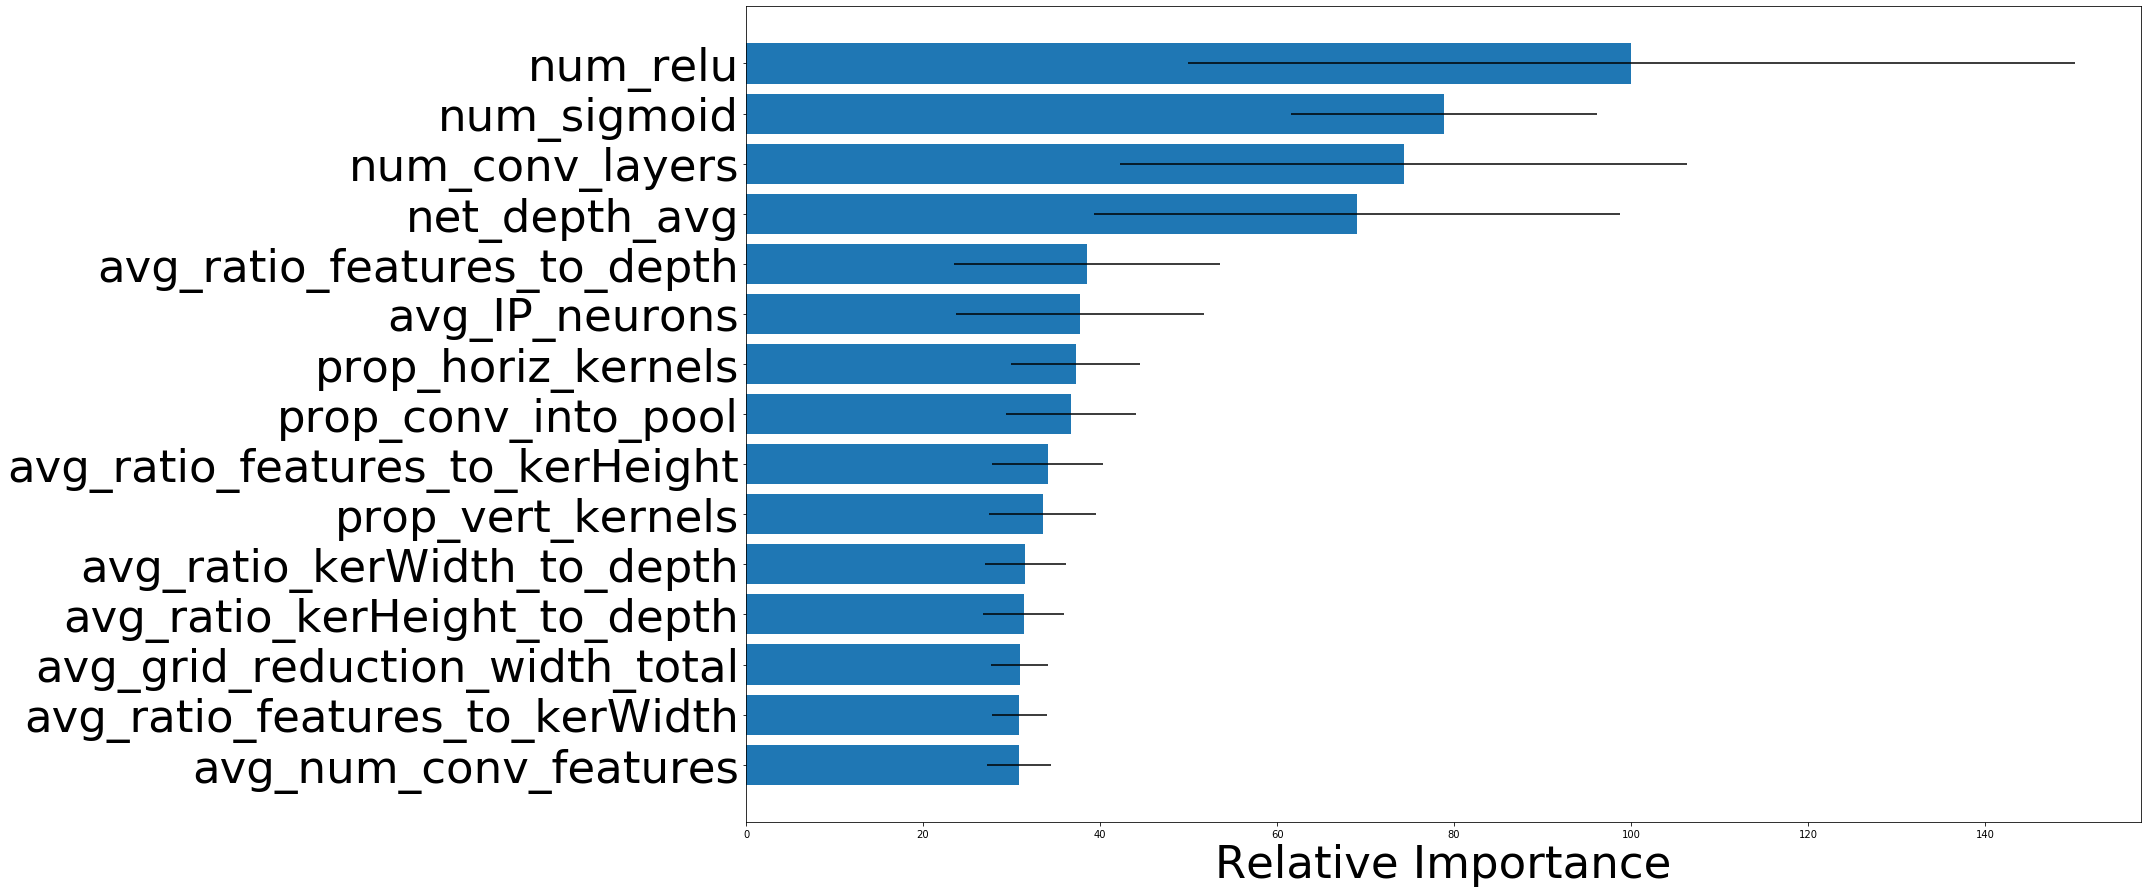

In [21]:
#Feature importance extraction from model
feature_importance11 = ext.feature_importances_

# Compute the standard deviation
std11 = np.std([tree.feature_importances_ for tree in ext.estimators_], axis=0)

#scale the std first
std11 = 100.0 * (std11/ feature_importance11.max())

# make importances relative to max importance
feature_importance11 = 100.0 * (feature_importance11 / feature_importance11.max())

features_importance_rf11 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance11, "Error":std11})

Sorted_Features_importance_rf11 = features_importance_rf11.sort_values(by=['Importance'])

#Just show the first 15 most important features
toShow_151 = Sorted_Features_importance_rf11.iloc[-15:,:]

pos = np.arange(toShow_151.shape[0]) + .5

fig = plt.figure(figsize = [25,15])
plt.barh(pos, toShow_151['Importance'], align='center', xerr = toShow_151['Error'])
plt.yticks(pos, toShow_151['Feature'], fontsize = 45)
plt.xlabel('Relative Importance', fontsize = 45)
plt.show()

In [24]:
#Feature importance extraction from model
feature_importance11 = ext.feature_importances_

# Compute the standard deviation
std11 = np.std([tree.feature_importances_ for tree in ext.estimators_], axis=0)

features_importance_rf11 = pd.DataFrame({'Feature':X.columns,'Importance':feature_importance11, "Error":std11})


In [51]:
features_importance_rf11.sort_values(by="Importance", ascending = False)

,Feature,Importance,Error
14,num_relu,0.088070,0.044131
15,num_sigmoid,0.069435,0.015206
1,num_conv_layers,0.065422,0.028176
0,net_depth_avg,0.060811,0.026181
25,avg_ratio_features_to_depth,0.033921,0.013207
3,avg_IP_neurons,0.033198,0.012345
12,prop_horiz_kernels,0.032786,0.006392
7,prop_conv_into_pool,0.032368,0.006465
28,avg_ratio_features_to_kerHeight,0.030036,0.005521
13,prop_vert_kernels,0.029520,0.005296


In [21]:
#Dropping most important features
ext_crvals, std_ext_crvals, ext_num_trimmed = drop_feature(ext, Sorted_Features_importance_rf11, X, y, 15)

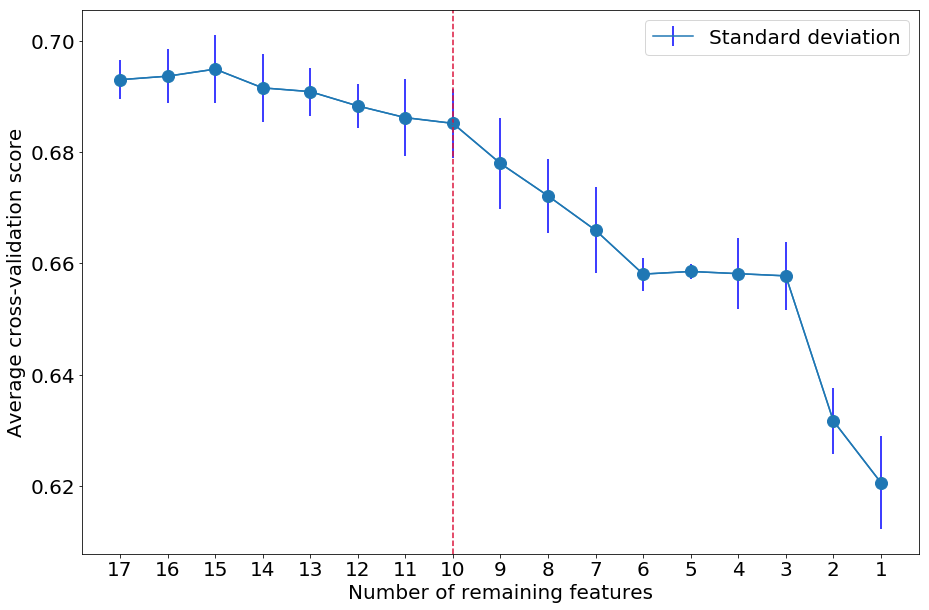

In [24]:
#Plotting
num_remaining = X.shape[1] - np.array(ext_num_trimmed)

fig = plt.figure(figsize = [15,10])
plt.plot(ext_num_trimmed, ext_crvals,'-o', markersize = 12)

#Set ticks
plt.yticks(fontsize = 20)
plt.xticks(ext_num_trimmed,num_remaining, fontsize = 20)

#Error bars
plt.errorbar(ext_num_trimmed, ext_crvals, yerr= std_ext_crvals, ecolor = "blue",
            label='Standard deviation')

plt.legend(loc="best", fontsize = 20)

#Set labels
plt.ylabel("Average cross-validation score", fontsize = 20)
plt.xlabel("Number of remaining features", fontsize = 20)

#Set cut off
plt.axvline(x = 22, ls = "--", c = "crimson")

---------------------

In [54]:
df = classification_df

In [55]:
df['group_name'] = ['Broken Networks' if x < 0.100533 else "Healthy Networks" for x in df['final_accuracy']]

Text(0.5, 0, '')

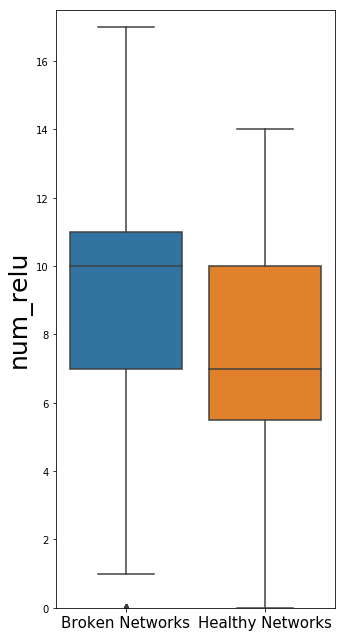

In [56]:
var = 'group_name'
data = pd.concat([df['num_relu'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='num_relu', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=17.50);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

Text(0.5, 0, '')

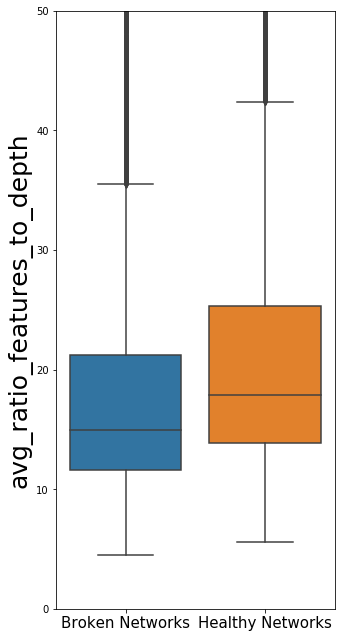

In [64]:
var = 'group_name'
data = pd.concat([df['avg_ratio_features_to_depth'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='avg_ratio_features_to_depth', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=50);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

Text(0.5, 0, '')

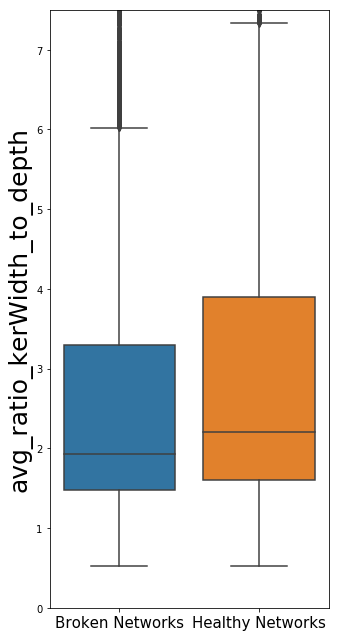

In [72]:
var = 'group_name'
data = pd.concat([df['avg_ratio_kerWidth_to_depth'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(5, 11))
fig = sns.boxplot(x=var, y='avg_ratio_kerWidth_to_depth', order = ["Broken Networks","Healthy Networks"], data=data)
fig.axis(ymin=0, ymax=7.5);
plt.xticks(fontsize=15);
ax.yaxis.label.set_size(25)
fig.set_xlabel('')

In [58]:
df['group'] = [0 if x < 0.100533 else 1 for x in df['final_accuracy']]

In [60]:
data1 = df[df['group'] == 0]
data2 = df[df['group'] == 1]

In [62]:
print("First group shape: ", data1.shape)
print("Second group shape: ", data2.shape)

First group shape:  (15771, 37)
Second group shape:  (15771, 37)


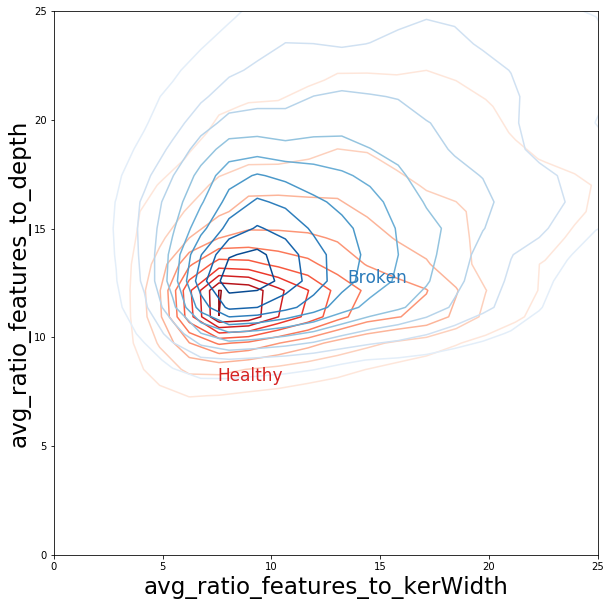

In [61]:
#avg_ratio_features_to_kerWidth and avg_ratio_features_to_depth
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerWidth'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=False, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerWidth'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=False, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(13.5, 12.5, "Broken", size=17, color=blue)
ax.text(7.5, 8, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)

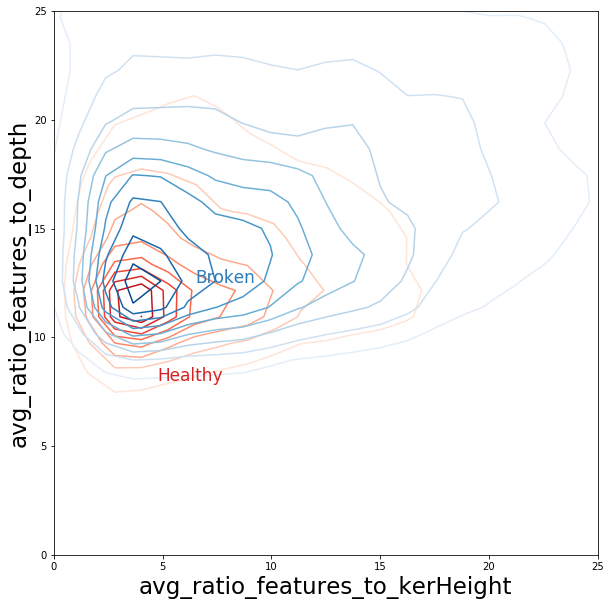

In [63]:
#avg_ratio_features_to_kerHeight and avg_ratio_features_to_depth
# Set up the figure
f, ax = plt.subplots(figsize=(10, 10))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(data1['avg_ratio_features_to_kerHeight'], data1['avg_ratio_features_to_depth'],
                 cmap="Reds", shade=False, shade_lowest=False)
ax = sns.kdeplot(data2['avg_ratio_features_to_kerHeight'], data2['avg_ratio_features_to_depth'],
                 cmap="Blues", shade=False, shade_lowest=False)

# Add labels to the plot
red = sns.color_palette("Reds")[-2]
blue = sns.color_palette("Blues")[-2]
ax.text(6.5, 12.5, "Broken", size=17, color=blue)
ax.text(4.75, 8, "Healthy", size=17, color=red)
plt.xlim(0,25)
plt.ylim(0,25)
ax.yaxis.label.set_size(23)
ax.xaxis.label.set_size(23)

---------------

In [8]:
#Linear models

In [23]:
#Select out the healthy parts
df = df[df["final_accuracy"] >= 0.100533]

In [24]:
print("Number of healthy networks: ", df.shape[0])

Number of healthy networks:  15771


In [25]:
import statsmodels.api as sm
from scipy import stats

Text(0.5, 1.0, 'Transformed Accuracy')

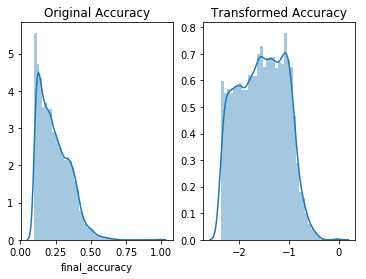

In [26]:
# normalize the exponential data with boxcox
normalized_accuracy = stats.boxcox(df["final_accuracy"])

# plot both together to compare
fig, ax=plt.subplots(1,2)
sns.distplot(df['final_accuracy'], ax=ax[0])
ax[0].set_title("Original Accuracy")
sns.distplot(normalized_accuracy[0], ax=ax[1])
ax[1].set_title("Transformed Accuracy")

In [18]:
#Feature + target
X = df.drop(columns=['initial_accuracy','final_accuracy', 'genealogy']) #Features
y = df['final_accuracy']

print("Feature's shape: ", X.shape)
print("Target's shape: ", y.shape)

Feature's shape:  (15771, 32)
Target's shape:  (15771,)


In [19]:
#Scale the inputs
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(X)  
X = scaler.transform(X) 

In [21]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(interaction_only = True, include_bias = False)
X = poly.fit_transform(X) #Create interaction terms

In [22]:
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:         final_accuracy   R-squared:                       0.298
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     13.08
Date:                Thu, 01 Aug 2019   Prob (F-statistic):               0.00
Time:                        08:50:03   Log-Likelihood:                 15628.
No. Observations:               15771   AIC:                        -3.026e+04
Df Residuals:                   15274   BIC:                        -2.645e+04
Df Model:                         496                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0355      0.017      2.048      0.0